In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [7]:
BASE_DIR = "Dataset"       
TRAIN_DIR = os.path.join(BASE_DIR, "train")
IMG_SIZE = (224, 224)     
CLASS_NAMES = ["real", "fake"]  

In [8]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        if not (fname.lower().endswith((".png", ".jpg", ".jpeg"))):
            continue
        try:
            img = Image.open(path).convert("RGB").resize(IMG_SIZE)
            arr = np.asarray(img, dtype=np.float32) / 255.0   
            images.append(arr)
            labels.append(label)
        except Exception as e:
            print("skipping", path, "error:", e)
    return images, labels

In [9]:
all_images = []
all_labels = []
for i, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(TRAIN_DIR, cls)
    imgs, labs = load_images_from_folder(folder, i)
    all_images.extend(imgs)
    all_labels.extend(labs)

image_data = np.array(all_images)   
labels = np.array(all_labels)      

print("Loaded:", image_data.shape, labels.shape, "class distribution:", np.bincount(labels))

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loaded: (479, 224, 224, 3) (479,) class distribution: [326 153]


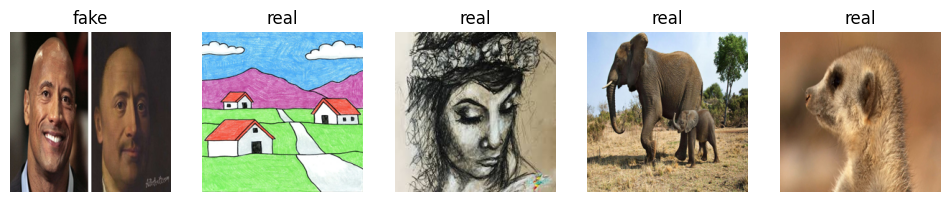

In [12]:
import random
n_show = 5
idx = random.sample(range(len(image_data)), n_show)

plt.figure(figsize=(12,6))
for i,j in enumerate(idx,1):
    plt.subplot(1, n_show, i)
    plt.imshow(image_data[j])
    plt.title(CLASS_NAMES[labels[j]])
    plt.axis("off")
plt.show()

In [13]:
X_train,X_test,Y_train,Y_test=train_test_split(image_data,labels,test_size=0.2,random_state=42,stratify=labels)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.3,random_state=42,stratify=Y_train)

In [16]:
X_train.shape # input size

(268, 224, 224, 3)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train) # to prevent overfitting

In [27]:
num_class=2
model=keras.models.Sequential(
    [
        keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,(3,3),activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(128,(3,3),activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dense(num_class,activation='softmax')
    ]
)

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history=model.fit(X_train,Y_train,epochs=10,batch_size=32,validation_data=(X_val,Y_val))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.5597 - loss: 1.0070 - val_accuracy: 0.6783 - val_loss: 0.6387
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6828 - loss: 0.6047 - val_accuracy: 0.6609 - val_loss: 0.5983
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 674ms/step - accuracy: 0.6978 - loss: 0.5740 - val_accuracy: 0.6609 - val_loss: 0.6161
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.7388 - loss: 0.5367 - val_accuracy: 0.6522 - val_loss: 0.6314
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 937ms/step - accuracy: 0.7836 - loss: 0.4672 - val_accuracy: 0.6609 - val_loss: 0.8280
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step - accuracy: 0.8545 - loss: 0.3669 - val_accuracy: 0.6609 - val_loss: 0.8204
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.8507 - loss: 0.3696 - val_accuracy: 0.6783 - val_loss: 0.7418
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step - accuracy: 0.9515 - loss: 0.2045 - val_accuracy: 0.7043 - val_loss: 0

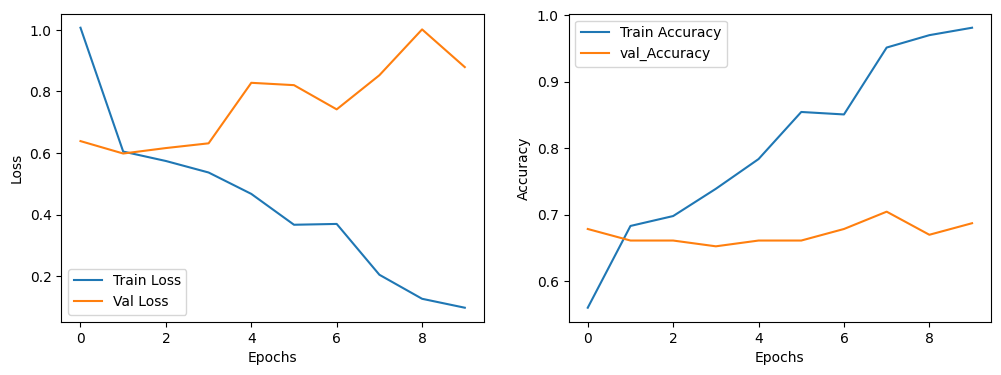

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
test_loss,test_accuracy=model.evaluate(X_test,Y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.7083 - loss: 0.9050


In [32]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9050, Test Accuracy: 0.7083


In [33]:
import joblib
joblib.dump(model, 'deepfake_detection_model.pkl')
print('Model saved Successfully')


Model saved Successfully
